In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

%ls -lah
working_path = "./drive/My Drive/Colab Notebooks/UFRGS/CV/TF"

Mounted at /content/drive
total 20K
drwxr-xr-x 1 root root 4.0K Apr  6 22:43 ./
drwxr-xr-x 1 root root 4.0K Apr  6 22:41 ../
drwxr-xr-x 4 root root 4.0K Mar 25 13:38 .config/
drwx------ 5 root root 4.0K Apr  6 22:43 drive/
drwxr-xr-x 1 root root 4.0K Mar 25 13:38 sample_data/


In [8]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

In [33]:
import pathlib as pl
import os.path as osp
import glob
import numpy as np
import cv2
from skimage import io, transform
import matplotlib.pyplot as plt

In [48]:
class BacteriaDataset(Dataset):
    """Bacteria dataset."""

    def __init__(self, base_path, is_train=True, augmentation=False, transform=None):
        self.images_list = sorted(glob.glob("/".join([base_path, "images"]) + "/*.png"))
        self.masks_list = sorted(glob.glob("/".join([base_path, "masks"]) + "/*.png"))
        self.transform = transform
        self.is_train = is_train
        self.total_samples = len(self.images_list)
        
    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        image = cv2.imread(self.images_list[idx], cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_list[idx], cv2.IMREAD_GRAYSCALE)
        sample = {'image': image, 'mask': mask}
        return sample

In [49]:
train_dataset = BacteriaDataset(base_path = "/".join([working_path, "data/train"]))

0 (1080, 1020, 3) (1080, 1020)
1 (1080, 848, 3) (1080, 848)
2 (1080, 880, 3) (1080, 880)
3 (1080, 880, 3) (1080, 880)


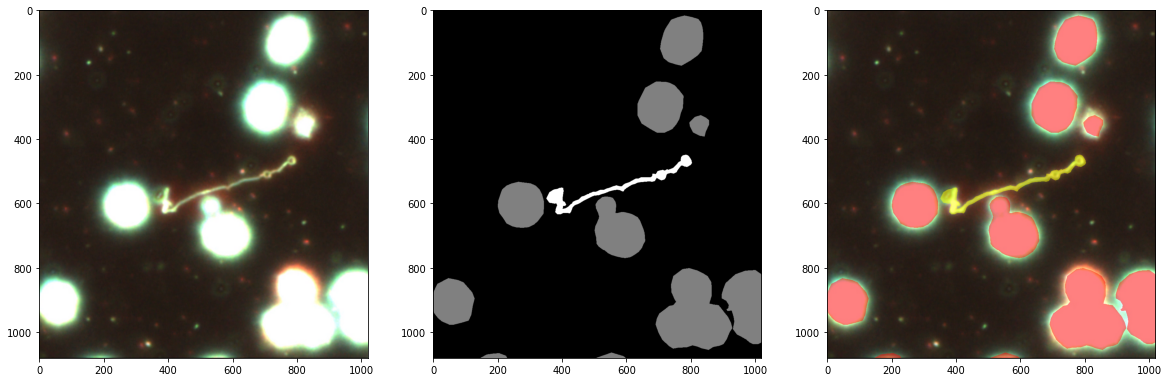

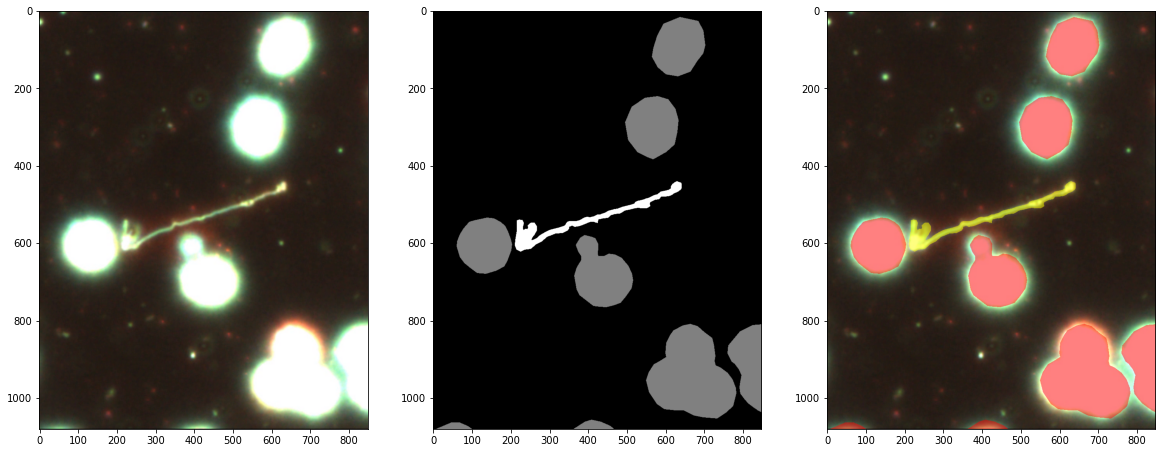

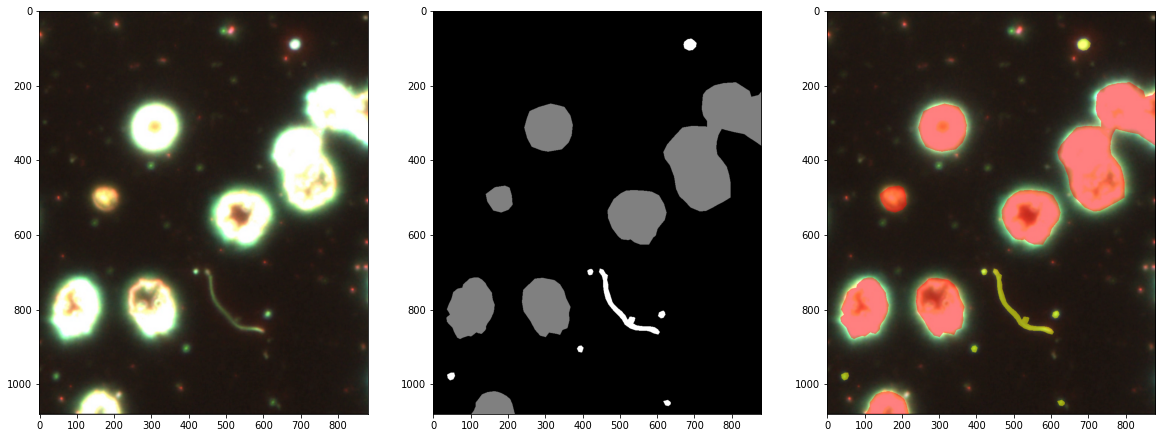

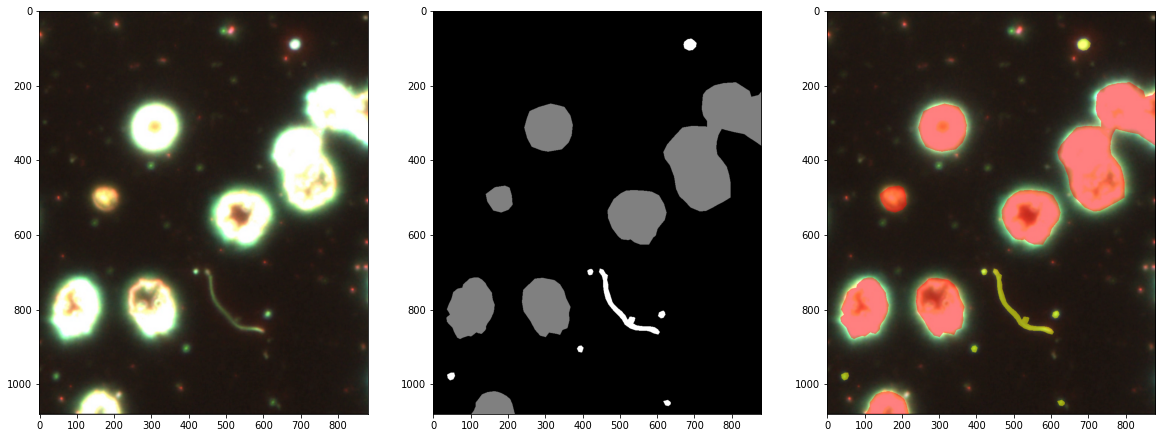

In [50]:
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    image = sample['image']
    mask = sample['mask']
    
    print(i, image.shape, mask.shape)
    
    mask_applied = image.copy()
    mask_applied[mask == 1] = [255, 0, 0]
    mask_applied[mask == 2] = [255, 255, 0]
    
    out = image.copy()
    mask_applied = cv2.addWeighted(mask_applied, 0.5, out, 0.5, 0, out)
    
    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(image)
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(mask, cmap="gray")
    ax3 = fig.add_subplot(1,3,3)
    ax3.imshow(mask_applied)

    if i == 3:
        break

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32

print(f"We are training on {device}")

We are training on cpu


In [5]:
print('==> Preparing data..')
transform_train = transforms.Compose(
    [transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose(
    [transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

==> Preparing data..
